In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [4]:
import sys
sys.path.append('../')

from tsdr import tsdr
from eval import groundtruth
from meltria import loader
from eval import validation

In [6]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

from meltria.priorknowledge.priorknowledge import SockShopKnowledge

sockshop_pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [5]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, {
        "services": True,
        "containers": True,
        "middlewares": False,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": True,
        "enable_multireducer": True,
        "step1_method_name": "residual_integral",
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_dbscan_min_pts": 1,
        "step2_dbscan_dist_type": "pearsonr",  # 'pearsonr' or 'sbd'
        "step2_dbscan_algorithm": "dbscan",  # 'dbscan' or 'hdbscan'
        "step2_clustering_series_type": "raw",  # 'raw', 'anomaly_score' or 'binary_anomaly_score'
        "step2_clustering_choice_method": "medoid",  # 'medoid' or 'maxsum'
    },
    use_manually_selected_metrics=True,
) 

## Check correlation

In [24]:
record, data_df_by_metric_type = dataset_by_chaos[("pod-memory-hog", "user")][1]
dataset = pd.concat([
    data_df_by_metric_type["containers"][-1],
    data_df_by_metric_type["services"][-1],
], axis=1)

from eval import validation

validation.examine_correlation_of_sli_and_cause_metrics(record)

,s-front-end_latency,s-front-end_throughput,s-front-end_errors,c-user_processes,c-user_memory_mapped_file,c-user_threads,c-user_memory_rss,c-user_ulimits_soft,c-user_memory_max_usage_bytes,c-user_memory_usage_bytes,c-user_sockets,c-user_memory_cache,c-user_memory_failures_total,c-user_memory_working_set_bytes,c-user_file_descriptors
s-front-end_latency,1.000000,-0.938502,-0.731610,NaN,0.312117,0.168795,0.345698,NaN,NaN,0.343326,NaN,0.172645,NaN,0.344890,NaN
s-front-end_throughput,-0.938502,1.000000,0.696560,NaN,-0.431868,-0.281797,-0.473056,NaN,NaN,-0.470557,NaN,-0.285238,NaN,-0.472175,NaN
s-front-end_errors,-0.731610,0.696560,1.000000,NaN,-0.052142,0.067087,-0.081398,NaN,NaN,-0.079452,NaN,0.062969,NaN,-0.080814,NaN
c-user_processes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c-user_memory_mapped_file,0.312117,-0.431868,-0.052142,NaN,1.000000,0.976888,0.960505,NaN,NaN,0.962044,NaN,0.985293,NaN,0.961906,NaN
c-user_threads,0.168795,-0.281797,0.067087,NaN,0.976888,1.000000,0.948960,NaN,NaN,0.950961,NaN,0.993803,NaN,0.950424,NaN
c-user_memory_rss,0.345698,-0.473056,-0.081398,NaN,0.960505,0.948960,1.000000,NaN,NaN,0.999977,NaN,0.932662,NaN,0.999984,NaN
c-user_ulimits_soft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c-user_memory_max_usage_bytes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
c-user_memory_usage_bytes,0.343326,-0.470557,-0.079452,NaN,0.962044,0.950961,0.999977,NaN,NaN,1.000000,NaN,0.934958,NaN,0.999998,NaN


188 0.8297018677923963


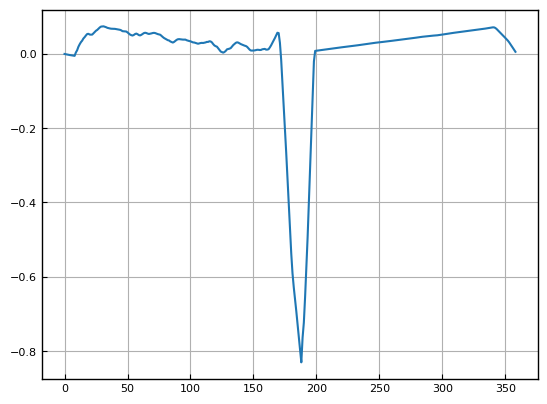

In [64]:
def xcorr(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    a_dev = a - a.mean()
    b_dev = b - b.mean()
    xc_ab = np.correlate(a_dev, b_dev, mode="full")
    # normalize
    xc_ab /= np.linalg.norm(a_dev, ord=2) * np.linalg.norm(b_dev, ord=2)
    return xc_ab

def xcorr_max(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    return np.max(np.abs(xcorr(a, b)))

out = xcorr(record.data_df["s-front-end_throughput"].to_numpy(), record.data_df["c-user_memory_usage_bytes"].to_numpy())
print(np.argmax(np.abs(out)), np.max(np.abs(out)))
plt.plot(out)

In [73]:
from diagnoser import diag

G, ranks = diag.build_and_walk_causal_graph(
    dataset,
    sockshop_pk,
    root_metric_type="latency",
    enable_prior_knowledge=False,
    use_call_graph=False,
    use_complete_graph=True,
    pc_library="pcalg",
    pc_citest_alpha=0.50,
    disable_orientation=False,
    walk_method="monitorrank",
    corr_method="xcorr",
)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [85]:
# check xcorr values
def xcorr_all(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    # expected X is 2darray, y is 1darray
    assert X.ndim == 2, f"X.ndim must be 2, but {X.ndim}"
    assert y.ndim == 1, f"y.ndim must be 1, but {y.ndim}"
    return np.apply_along_axis(lambda x: xcorr(x, y), axis=1, arr=X)

metrics = [metric for metric, val in ranks]
xcorr_vals = dataset.filter(items=metrics).apply(lambda x: xcorr_max(x.to_numpy(), record.data_df["s-front-end_latency"].to_numpy()), axis=0).sort_values(ascending=False)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(xcorr_vals)


s-front-end_throughput                        0.938502
s-payment_throughput                          0.937615
s-carts_throughput                            0.934043
s-catalogue_throughput                        0.932440
s-user_throughput                             0.931743
s-shipping_throughput                         0.927369
s-orders_throughput                           0.919578
c-front-end_memory_usage_bytes                0.901073
c-shipping_network_receive_bytes_total        0.898829
c-catalogue_network_receive_packets_total     0.898137
c-front-end_network_receive_packets_total     0.895137
c-user_network_receive_packets_total          0.894700
c-orders-db_fs_writes_total                   0.892700
c-orders_network_receive_bytes_total          0.886782
c-catalogue_cpu_usage_seconds_total           0.886527
c-payment_cpu_usage_seconds_total             0.886216
c-catalogue_cpu_system_seconds_total          0.886140
c-catalogue_cpu_user_seconds_total            0.881411
c-catalogu

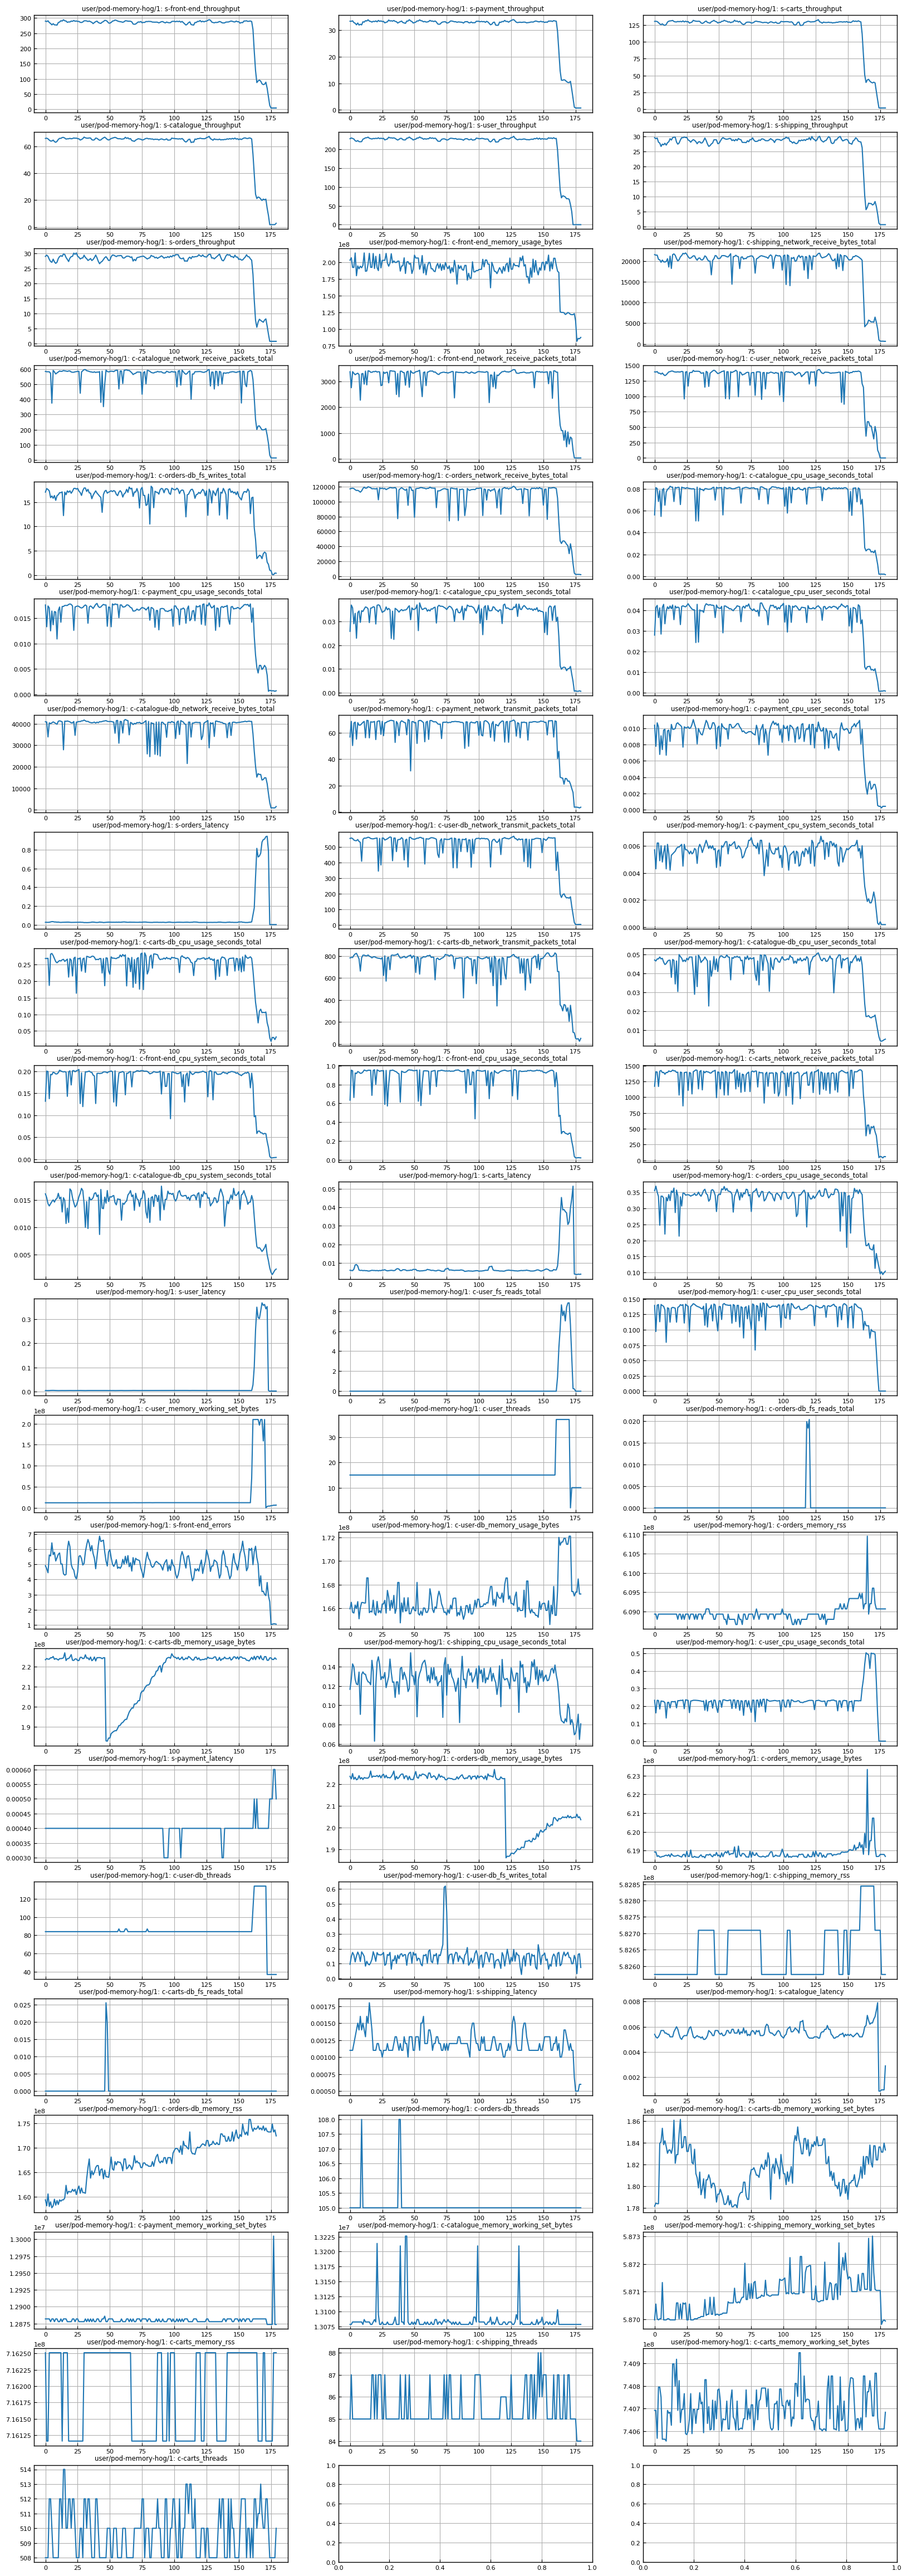

In [86]:
from notebooklib import plot
plot.plot_dataset_dataframe(dataset.filter(items=xcorr_vals.index.to_list()), record)

In [87]:
ranks[0:15]

[('c-shipping_network_receive_bytes_total', 0.02315500606060485),
 ('c-payment_cpu_usage_seconds_total', 0.022730720182484444),
 ('s-shipping_throughput', 0.0224377520423547),
 ('c-payment_cpu_user_seconds_total', 0.022400950808892088),
 ('c-payment_network_transmit_packets_total', 0.022316214839385652),
 ('c-user-db_network_transmit_packets_total', 0.022229786769302734),
 ('c-catalogue-db_network_receive_bytes_total', 0.02216234963986702),
 ('s-payment_throughput', 0.022161101261888642),
 ('c-payment_cpu_system_seconds_total', 0.02211653169775641),
 ('c-carts-db_cpu_usage_seconds_total', 0.022115419346510203),
 ('c-catalogue-db_cpu_user_seconds_total', 0.022035775208276934),
 ('c-carts-db_network_transmit_packets_total', 0.02186323614238001),
 ('c-catalogue-db_cpu_system_seconds_total', 0.021725468088250995),
 ('c-catalogue_network_receive_packets_total', 0.021628549027534905),
 ('c-catalogue_cpu_usage_seconds_total', 0.021566717538841658)]

## Causality package

In [47]:
from diagnoser import diag

G, ranks = diag.build_and_walk_causal_graph(
    dataset,
    sockshop_pk,
    root_metric_type="latency",
    enable_prior_knowledge=False,
    use_call_graph=False,
    use_complete_graph=False,
    pc_library="causality",
    pc_citest_alpha=0.50,
    disable_orientation=False,
    walk_method="monitorrank",
    corr_method="pearsonr",
)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
Estimated scale is 0.0 indicating that the most last it

KeyboardInterrupt: 

In [20]:
from notebooklib import rank

ranks

[('c-payment_cpu_usage_seconds_total', 0.06725194645283582),
 ('c-carts_network_receive_packets_total', 0.05833783452455375),
 ('c-shipping_network_receive_bytes_total', 0.04870510847441477),
 ('c-payment_cpu_user_seconds_total', 0.04593445292731501),
 ('c-catalogue-db_network_receive_bytes_total', 0.03502755859437058),
 ('c-catalogue-db_cpu_system_seconds_total', 0.03369045922641807),
 ('c-orders-db_fs_writes_total', 0.033589203577340764),
 ('c-user_network_receive_packets_total', 0.03314945585709684),
 ('c-payment_cpu_system_seconds_total', 0.032542100944016036),
 ('c-front-end_memory_usage_bytes', 0.029530629444036165),
 ('c-user_fs_reads_total', 0.029209834544053244),
 ('s-catalogue_throughput', 0.028798906691344224),
 ('s-user_throughput', 0.02879262723235672),
 ('c-user-db_network_transmit_packets_total', 0.027992800281642444),
 ('c-payment_network_transmit_packets_total', 0.027132049285406218),
 ('s-payment_throughput', 0.02537197543695229),
 ('c-carts-db_network_transmit_packet

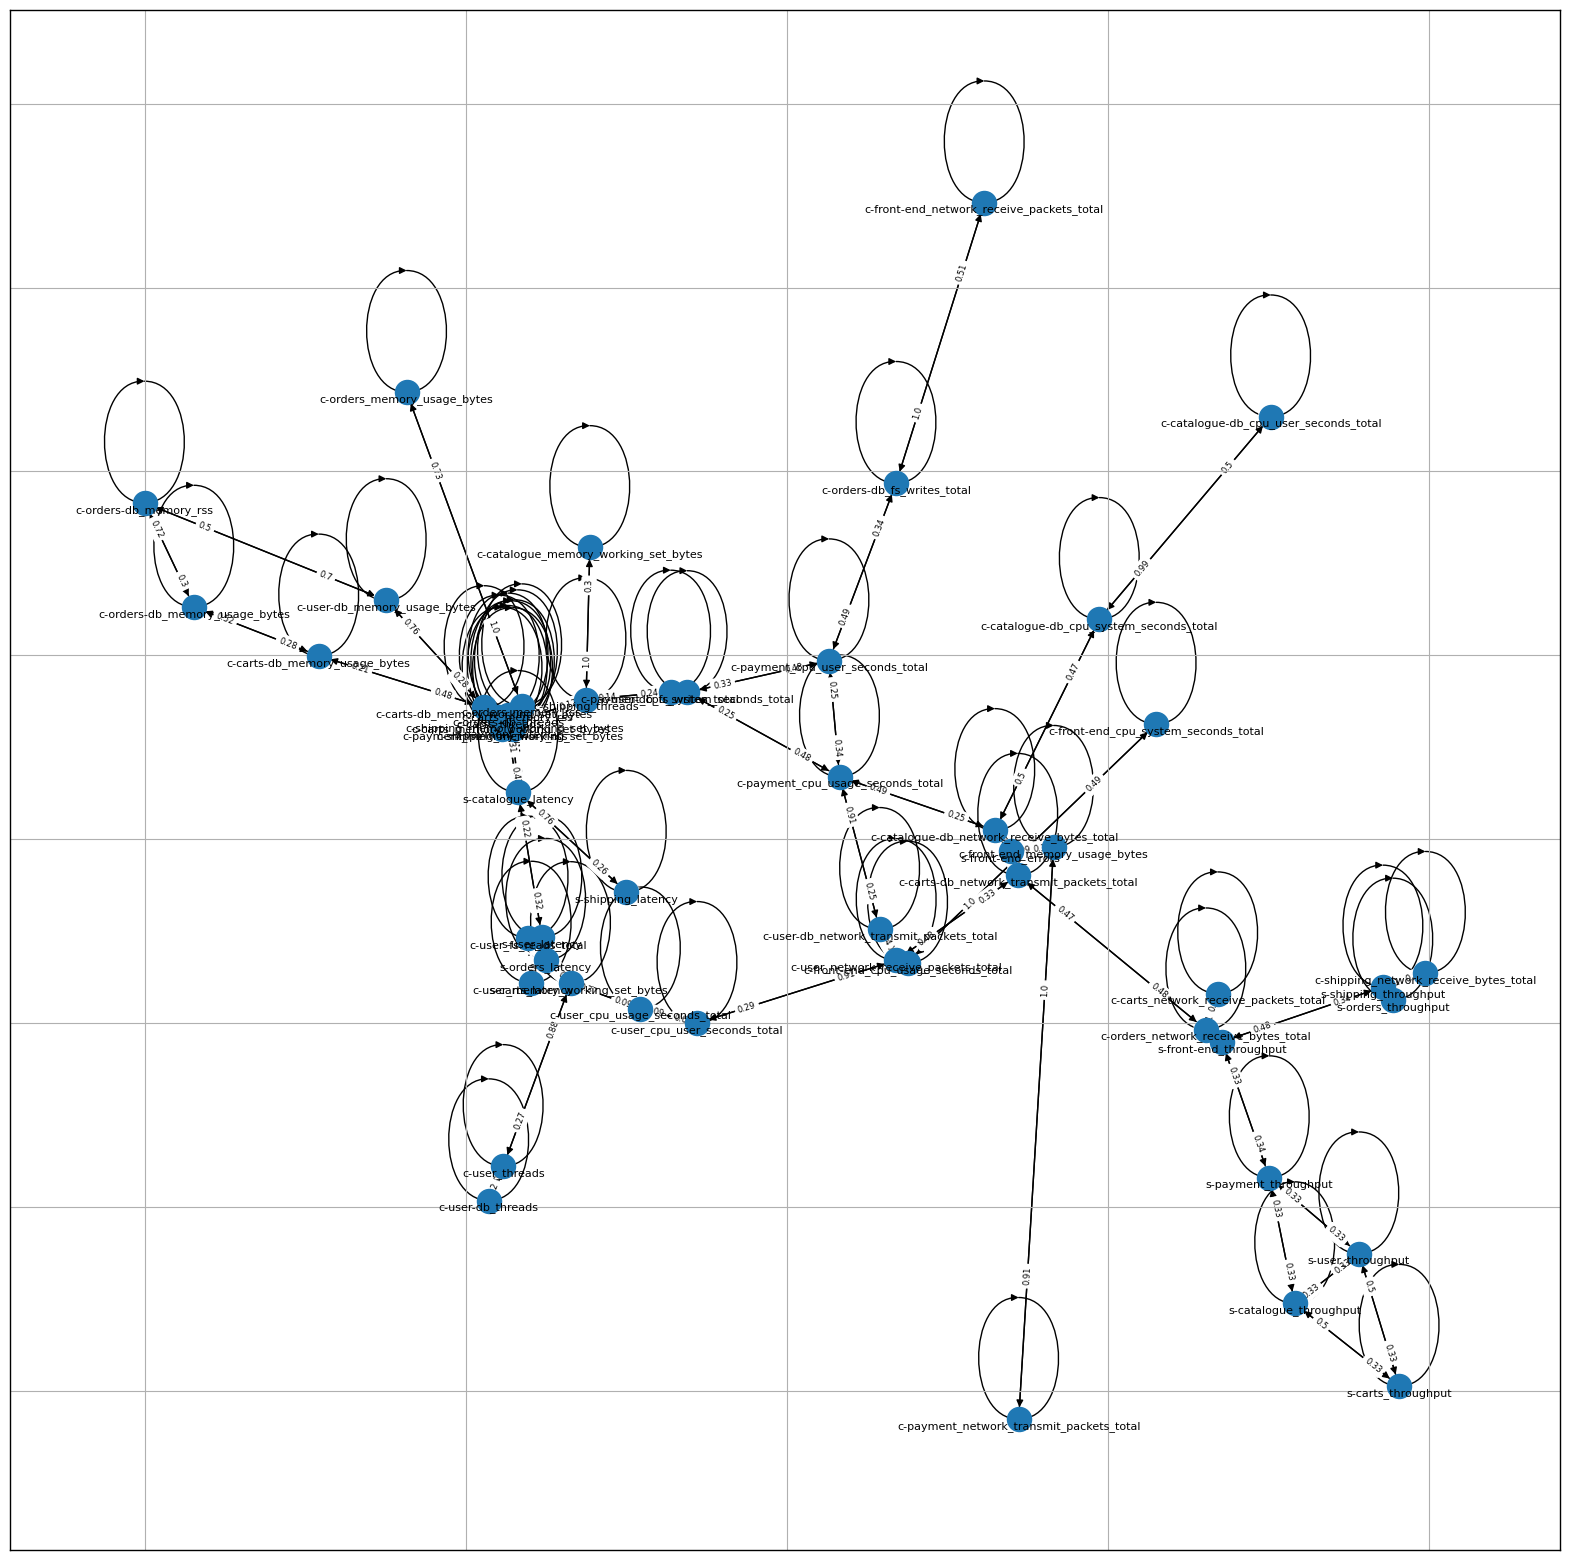

In [21]:
from notebooklib import plot

plot.plot_causal_graph(G)

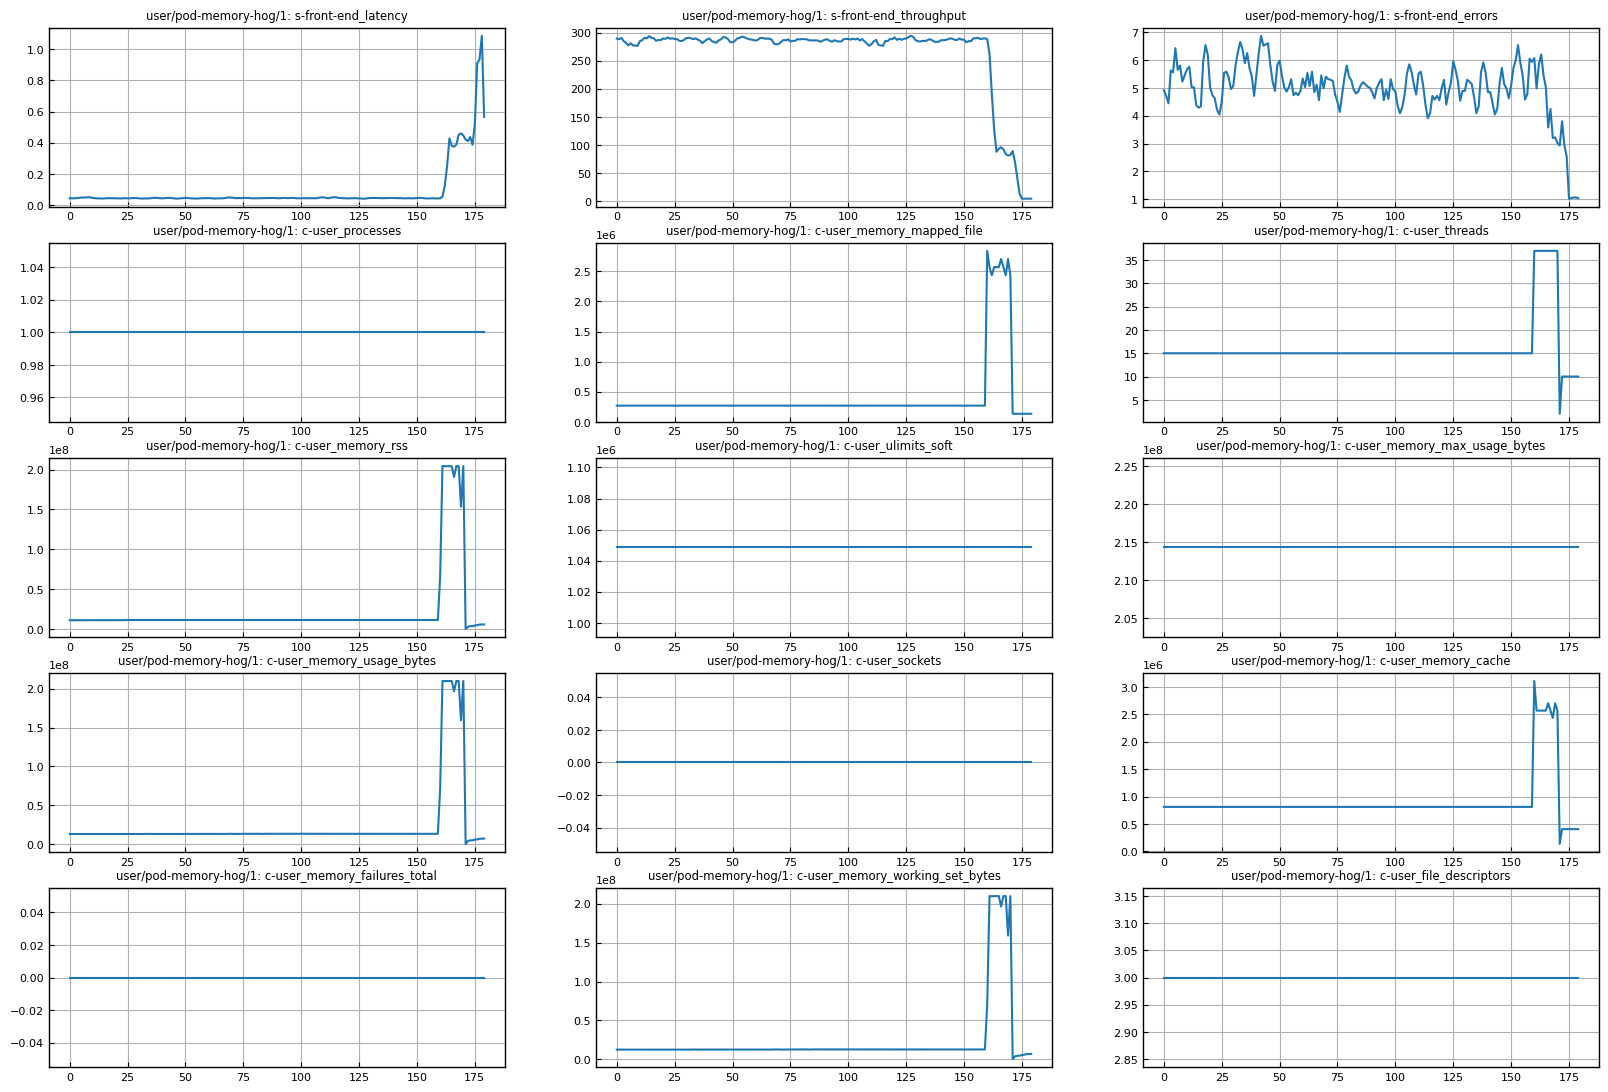

In [23]:
plot.plot_sli_and_causal_metrics(record)

In [45]:
G, ranks = diag.build_and_walk_causal_graph(
    dataset,
    sockshop_pk,
    root_metric_type="latency",
    enable_prior_knowledge=False,
    use_call_graph=False,
    use_complete_graph=False,
    pc_library="causality",
    pc_citest_alpha=0.50,
    disable_orientation=False,
    walk_method="monitorrank",
    corr_method="xcorr",
)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
Estimated scale is 0.0 indicating that the most last it

In [46]:
ranks[0:10]

[('c-payment_cpu_usage_seconds_total', 0.07011302409737229),
 ('c-carts_network_receive_packets_total', 0.060943148023298074),
 ('c-shipping_network_receive_bytes_total', 0.05086062297459735),
 ('c-payment_cpu_user_seconds_total', 0.047854159989952044),
 ('c-catalogue-db_network_receive_bytes_total', 0.036545012396836996),
 ('c-catalogue-db_cpu_system_seconds_total', 0.03516152953832782),
 ('c-orders-db_fs_writes_total', 0.03502487987968817),
 ('c-user_network_receive_packets_total', 0.0346982801026697),
 ('c-payment_cpu_system_seconds_total', 0.03448467600785772),
 ('c-front-end_memory_usage_bytes', 0.03083739215504994)]